In [2]:
import testing_process as tp
import importlib
import pandas as pd
importlib.reload(tp)
import warnings
import re
warnings.simplefilter(action='ignore', category=Warning)
from prophet import Prophet

c:\Users\Le-Hao.Hsu\OneDrive - Foxconn Industrial Internet in North America\Desktop\Gavin\cims_test


### PO Data Process

In [7]:
po_df = pd.read_excel('1149170_PO.XLSX')
po_df.columns

Index(['PO Number', 'PO Item', 'PO Type', 'Vendor', 'Vendor Name',
       'Purchasing Group', 'Buyer Name', 'Plant', 'Material',
       'Material Description', 'Manufacturer PartNo', 'Manufacturer Name',
       'Mfr Name', 'Batch', 'NBM Code', 'Invoice Qty.', 'Unit of Measure',
       'Net Price', 'Currency', 'Price Unit', 'Deletion Indicator',
       'Delivery completed', 'PO Document Date', 'Create By', 'Total GR Qty',
       'SLoc', 'Your Reference', 'Schedule No', 'Delivery date',
       'Scheduled Qty', 'Delivery Qty', 'Open Qty', 'Invoice', 'Invoice Date',
       'Quantity', 'Short Text', 'Item Category', 'Incoterms1', 'Incoterms2',
       'Salesperson', 'Returns Item', 'Lead Time', 'Pioneer Dlv Date',
       'PR Number', 'PR Item', 'PR Release Date', 'Payment Terms',
       'Our Reference', 'Release group', 'Release Strategy',
       'Release Indicator', 'Planner', 'Reqmt No.', 'AcctAssCat', 'Exch. Rate',
       'Cost Center', 'G/L Account'],
      dtype='object')

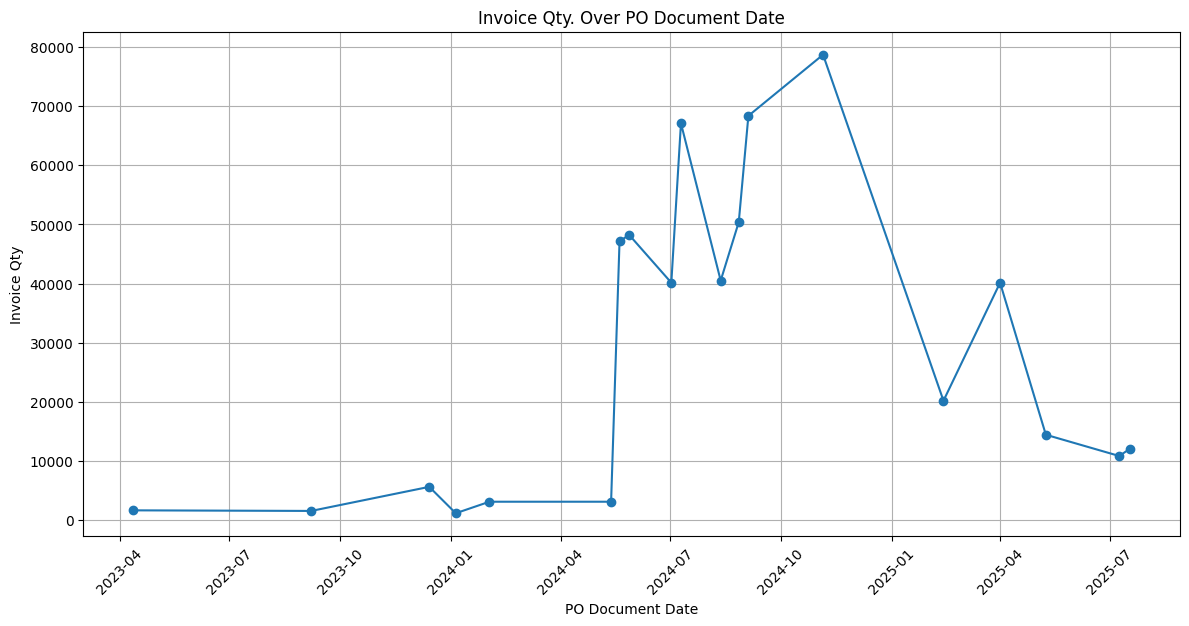

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure PO document date is in datetime format
po_df['PO Document Date'] = pd.to_datetime(po_df['PO Document Date'])

# Group by PO document date (optional if already daily)
daily_gr = po_df.groupby('PO Document Date')['Invoice Qty.'].sum().reset_index()

# Sort by date
daily_gr = daily_gr.sort_values('PO Document Date')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_gr['PO Document Date'], daily_gr['Invoice Qty.'], marker='o')
plt.title('Invoice Qty. Over PO Document Date')
plt.xlabel('PO Document Date')
plt.ylabel('Invoice Qty')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


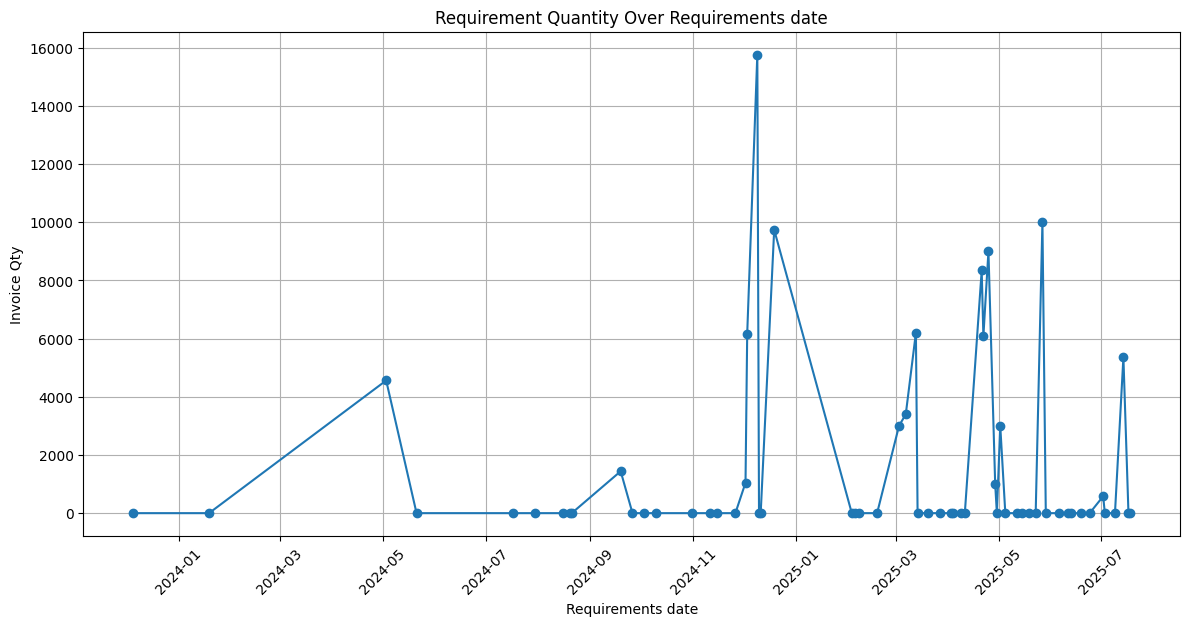

In [14]:
inv_df = pd.read_excel('1152063-01_reserved_inventory.XLSX')
# Ensure PO document date is in datetime format
inv_df['Requirements date'] = pd.to_datetime(inv_df['Requirements date'])

# Group by PO document date (optional if already daily)
daily_gr = inv_df.groupby('Requirements date')['Requirement Quantity'].sum().reset_index()

# Sort by date
daily_gr = daily_gr.sort_values('Requirements date')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_gr['Requirements date'], daily_gr['Requirement Quantity'], marker='o')
plt.title('Requirement Quantity Over Requirements date')
plt.xlabel('Requirements date')
plt.ylabel('Invoice Qty')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Shortage Report Process

In [107]:
sr_df = pd.read_excel('L10_SR.xlsx', sheet_name='Shortage1')
project_build_plan_idx = sr_df.columns.get_loc("Projects Build Plan")
project_build_plan_cols = sr_df.columns[project_build_plan_idx:]

# Drop columns that are completely NaN
valid_cols = project_build_plan_cols[~sr_df[project_build_plan_cols].isna().all()]

# Take columns only up to (not including) the first all-NaN column
for i, col in enumerate(valid_cols):
    if sr_df[col].isna().all():
        final_cols = valid_cols[:i]
        break
else:
    final_cols = valid_cols



project_build_plan_df = sr_df[final_cols]
project_build_plan_df = project_build_plan_df.loc[:, ~project_build_plan_df.columns.str.startswith('Unnamed')]

first_col = project_build_plan_df.columns[0]
start_row = project_build_plan_df[project_build_plan_df[first_col] == 'Material Status'].index
project_build_plan_df = project_build_plan_df.loc[:start_row[0]-1].reset_index(drop=True)



material_df = sr_df.loc[start_row[0]-1:]
# Assuming df is your original DataFrame
header_rows = material_df.iloc[1:5]  # Top 5 rows to construct multirow header

# Fill forward, then collapse header rows into single row
collapsed_headers = header_rows.fillna('').astype(str).agg(' '.join).str.strip().str.replace(' +', ' ', regex=True)
material_df.columns = collapsed_headers

# Drop header rows
final_material_df = material_df.iloc[5:].iloc[::6]
final_material_idx = final_material_df.columns.get_loc("Open PO Date")
final_material_df = final_material_df.iloc[:, :final_material_idx]



customer_pn_lst = list(project_build_plan_df['Projects Build Plan'][1:])
# Step 1: Get the current column names as a list
all_cols = list(final_material_df.columns)

# Step 2: Replace the last n columns with customer_pn_lst
new_cols = all_cols[:len(all_cols) - len(customer_pn_lst)] + customer_pn_lst

# Step 3: Assign back to DataFrame
final_material_df.columns = new_cols
final_material_df.iloc[:, -len(customer_pn_lst):] = final_material_df.iloc[:, -len(customer_pn_lst):].fillna(0)


project_pn = '1182051'
# Step 1: Filter rows where the target column is not 0
filtered_df = final_material_df[final_material_df[project_pn] != 0]

# Step 2: Select first 6 columns + the target column (if not already included)
cols_to_keep = list(final_material_df.columns[:6])

if project_pn not in cols_to_keep:
    cols_to_keep.append(project_pn)

# Step 3: Slice the DataFrame
result_df = filtered_df[cols_to_keep]

In [121]:
pn_lst = result_df['HHPN MPN Supplier/Manufacturer Customer PN'].to_list()

### BOM data Process

In [169]:
bom_df = pd.read_csv('1182051_bom.XLSX')[['Item Number', 'Component number', 'Object description', 'Assembly indicator']]


In [167]:
# Step 1: Flag NaNs to start new groups AFTER them
group_id = (~bom_df["Item Number"].notna()).cumsum()

# Step 2: Exclude rows that are NaN (they're just separators)
df_valid = bom_df[bom_df["Item Number"].notna()].copy()
df_valid["Group"] = group_id[bom_df["Item Number"].notna()].values

# Step 3: Group and print
for group, group_df in df_valid.groupby("Group"):
    print(f"\nGroup {group}")
    print(group_df[["Item Number", "Component number", "Object description"]])


Group 0
    Item Number Component number                        Object description
0          10.0       1136907-01  Assy, Diorite B1 FullRock 48GB, 1x200GbE
1          20.0       1107157-01  Cable, HDMI, Standard Type A Male-to- St
2          30.0       1098823-01  Cable, Power, Diorite to Dedicated Conn,
3          40.0       1112593-02  ASM, Tray Cover, Air Baffle, Astoria, EV
4          40.0   1112593-02-FLG  ASM, Tray Cover, Air Baffle, Astoria(FLE
5          50.0          1134400                    Assy, x16x16 IO Module
6          50.0       1134400-01  Assy, x16x16 IO Module Bracket, Improved
7          50.0   1134400-01-FGZ  Assy, x16x16 IO Module Bracket, Improved
8          50.0   1134400-01-FLG  Assy, x16x16 IO Module Bracket, Improved
9          50.0      1134400-FLG  Assy, x16x16 IO Module Bracket, Improved
10         60.0          1114467  Screw, Flathead, Low thickness head, Phi
11         70.0          1136798  Options, CSSD-PH2X, PCBA, 128GB Raw, 100
12         80.0 

In [80]:
query = '''
                    SELECT wo.workorder_id, wo.sap_release_date, wo.target_qty, wo.finished_qty, wo.skuno,
                            sn.serial_number, sn.pack_date, sn.ship_date, sn.completed, sn.shipped, wo.
                    FROM manufacturing_workorder wo
                    JOIN manufacturing_serialnumber sn 
                    ON wo.workorder_id = sn.workorder_id
                    WHERE skuno = '1182051'
                    '''
df = tp.db_connect(query)

In [106]:
df[df['completed']==0]

,workorder_id,sap_release_date,target_qty,finished_qty,skuno,serial_number,pack_date,ship_date,completed,shipped
38053,000007007973,2024-11-15 18:58:49-06:00,1200,1200,1182051,FWI2446-14877,None,None,0,0
45219,000007008431,2024-12-11 17:23:27-06:00,1500,1500,1182051,FWI2450-06362,None,None,0,0
48015,000007008459,2024-12-13 16:44:50-06:00,2000,2000,1182051,FWI2450-17904,None,None,0,0
60735,000007007654,2024-10-18 15:15:39-05:00,1000,1000,1182051,FWI2442-15834,None,None,0,0
72129,000007008040,2024-11-20 19:45:42-06:00,1235,1235,1182051,FWI2447-05261,None,None,0,0
...,...,...,...,...,...,...,...,...,...,...
238880,000007012110,2025-06-26 15:45:15-05:00,1810,1810,1182051,FWI2526-12021,None,None,0,0
238881,000007012110,2025-06-26 15:45:15-05:00,1810,1810,1182051,FWI2526-12023,None,None,0,0
243500,000007011743,2025-06-10 11:29:44-05:00,60,60,1182051,FWI2524-04213,None,None,0,0
243503,000007011743,2025-06-10 11:29:44-05:00,60,60,1182051,FWI2524-04211,None,None,0,0


In [86]:
notship_wo = df[df['shipped']!=1].workorder_id.unique()

In [90]:
df[(df['shipped']!=1)&(df['workorder_id'].isin(notship_wo))].groupby("workorder_id").filter(lambda x: len(x) > 1)

,workorder_id,sap_release_date,target_qty,finished_qty,skuno,serial_number,pack_date,ship_date,completed,shipped
20917,000007006364,2024-06-21 16:40:08-05:00,666,666,1182051,FWI2426-09152,None,None,1,0
20956,000007006364,2024-06-21 16:40:08-05:00,666,666,1182051,FWI2426-08994,2024-09-12 14:54:12.976676-05:00,None,1,0
21005,000007006364,2024-06-21 16:40:08-05:00,666,666,1182051,FWI2426-09331,2025-06-28 11:05:46.353931-05:00,None,1,0
27987,000007007549,2024-10-10 17:00:51-05:00,1200,1200,1182051,FWI2441-10520,2024-11-04 21:51:39.074680-06:00,None,1,0
28294,000007007549,2024-10-10 17:00:51-05:00,1200,1200,1182051,FWI2441-11019,2025-02-04 07:46:47.054137-06:00,None,1,0
...,...,...,...,...,...,...,...,...,...,...
246674,000007011754,2025-06-12 15:45:25-05:00,2227,2227,1182051,FWI2524-15901,2025-06-20 18:52:51.625994-05:00,None,1,0
246677,000007011754,2025-06-12 15:45:25-05:00,2227,2227,1182051,FWI2524-16219,2025-06-20 18:25:33.150589-05:00,None,1,0
246716,000007011754,2025-06-12 15:45:25-05:00,2227,2227,1182051,FWI2524-15639,2025-06-24 19:43:45.984428-05:00,None,1,0
246723,000007011754,2025-06-12 15:45:25-05:00,2227,2227,1182051,FWI2524-14902,2025-07-03 11:02:46.389470-05:00,None,1,0


In [99]:
query = '''
                    SELECT serial_number, station, in_station_time
                    FROM manufacturing_serialnumberlog 
                    WHERE serial_number = 'FWI2441-11019'
                    '''
sn_df = tp.db_connect(query)

query = '''
                    SELECT serial_number, line, from_station, to_station, in_station_time, out_station_time, shift, station_type 
                    FROM manufacturing_l10serialnumberlog 
                    WHERE serial_number = 'FWI2441-11019'
                    '''
l10_sn_df = tp.db_connect(query)

In [104]:
l10_sn_df

,serial_number,line,from_station,to_station,in_station_time,out_station_time,shift,station_type
0,FWI2441-11019,cline2,AST Manual 1,AST--FAN,2024-10-15 10:22:30.117292-05:00,2024-10-15 10:24:09.922128-05:00,1,Assembly
1,FWI2441-11019,cline2,AST--FAN,AST--DIMM,2024-10-15 10:26:53.505390-05:00,2024-10-15 10:28:32.953369-05:00,1,Assembly
2,FWI2441-11019,cline2,AST--DIMM,AST Manual 2,2024-10-15 10:28:34.786464-05:00,2024-10-15 10:32:39.485242-05:00,1,Assembly
3,FWI2441-11019,cline2,AST Manual 2,AST Manual 3,2024-10-15 10:34:13.328124-05:00,2024-10-15 10:35:28.194095-05:00,1,Assembly
4,FWI2441-11019,cline2,AST Manual 3,AST Manual 4,2024-10-15 10:35:34.540995-05:00,2024-10-15 10:37:21.585407-05:00,1,Assembly
5,FWI2441-11019,cline2,AST Manual 4,AST Manual 5,2024-10-15 10:41:44.374338-05:00,2024-10-15 10:42:40.785490-05:00,1,Assembly
6,FWI2441-11019,cline2,AST Manual 5,AST Pre-Test,2024-10-15 10:43:35.442784-05:00,2024-10-15 10:45:39.926592-05:00,1,Assembly
7,FWI2441-11019,cline2,AST Pre-Test,AST Functional Test,2024-10-15 21:02:53.014497-05:00,2024-10-15 21:54:46.733652-05:00,3,Test
8,FWI2441-11019,cline2,AST Functional Test,Repair,2024-10-16 09:12:24.730443-05:00,2024-10-16 10:48:39.453090-05:00,1,Test
9,FWI2441-11019,cline2,Repair,AST Functional Test,2024-10-16 12:34:18.916244-05:00,2024-10-16 12:36:45.870853-05:00,1,Repair


### MRP Data Process

In [15]:
with open("mrp.csv", encoding="utf-8") as f:
    lines = f.readlines()

rows = [line.strip().split('\t') for line in lines]

df = pd.DataFrame(rows[1:], columns=rows[0])
# 1. Fix column name
df.columns = [col.lstrip('"') for col in df.columns]

# 2. Fix all values in the first column (now likely named 'Material')
df.iloc[:, 0] = df.iloc[:, 0].str.lstrip('"')
df = df.iloc[:, :82]

In [16]:
df.iloc[:,:20]

,Material,Plant,Version,MRP Area,W 24/2025,W 25/2025,W 26/2025,W 27/2025,W 28/2025,W 29/2025,W 30/2025,W 31/2025,W 32/2025,W 33/2025,W 34/2025,W 35/2025,W 36/2025,W 37/2025,W 38/2025,W 39/2025
0,1138092,FWX1,[00],FWX1_MRP,0.000,0.000,0.000,0.000,1425.000,0.000,0.000,0.000,0.000,0.000,2000.000,,,0.000,2000.000,
1,1138093,FWX1,[00],FWX1_MRP,0.000,0.000,0.000,0.000,705.000,0.000,0.000,0.000,0.000,0.000,1000.000,0.000,0.000,0.000,1000.000,0.000
2,1141740,FWX1,[00],FWX1_MRP,17963.000,2230.000,3272.000,2606.000,488.000,2540.000,1580.000,1018.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1141741,FWX1,[00],FWX1_MRP,9101.000,1115.000,1635.000,1303.000,244.000,1270.000,790.000,509.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,1142913,FWX1,[00],FWX1_MRP,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,,,,,0.000,0.000,0.000,0.000
5,1154427,FWX1,[00],FWX1_MRP,1893.000,614.000,314.000,216.000,207.000,166.000,0.000,139.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,1154503,FWX1,[00],FWX1_MRP,0.000,0.000,,,,,,,,,,,,,,
7,1154508,FWX1,[00],FWX1_MRP,,,,,,,,,,,0.000,0.000,0.000,0.000,0.000,0.000
8,1157647,FWX1,[00],FWX1_MRP,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,1158438,FWX1,[00],FWX1_MRP,398.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
